In [15]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from joblib import parallel_backend
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

galaxy_data = pd.read_csv("clean_data.csv")
# galaxy_data = galaxy_data.head(1000)
all_inputs = galaxy_data.drop(columns=["subclass"]).values

galaxy_data_normalized = pd.read_csv("clean_data_normalized.csv")
# galaxy_data_normalized = galaxy_data_normalized.head(1000)
all_inputs_normalized = galaxy_data_normalized.drop(columns=["subclass"]).values

all_labels = galaxy_data["subclass"].values
nr_features = all_inputs.shape[1]

In [109]:
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(
    all_inputs, all_labels, test_size=0.25
)

In [110]:
(training_inputs_normalized, testing_inputs_normalized, training_classes_normalized, testing_classes_normalized) = train_test_split(
    all_inputs_normalized, all_labels, test_size=0.25
)

In [7]:
under_sampler = RandomUnderSampler()
inputs_under_sampl, labels_under_sampl = under_sampler.fit_resample(all_inputs, all_labels)
inputs_under_sampl_normalized, labels_under_sampl_normalized = under_sampler.fit_resample(all_inputs_normalized, all_labels)

len(labels_under_sampl_normalized[labels_under_sampl_normalized == "STARBURST"]), len(labels_under_sampl_normalized[labels_under_sampl_normalized == "STARFORMING"])

(23960, 23960)

In [9]:
over_sampler = RandomOverSampler()
inputs_over_sampl, labels_over_sampl = over_sampler.fit_resample(all_inputs, all_labels)
inputs_over_sampl_normalized, labels_over_sampl_normalized = over_sampler.fit_resample(all_inputs_normalized, all_labels)

len(labels_over_sampl_normalized[labels_over_sampl_normalized == "STARBURST"]), len(labels_over_sampl_normalized[labels_over_sampl_normalized == "STARFORMING"])

(73517, 73517)

In [10]:
def test_classifier(clf, data, labels, parameter_grid, **kwargs):
    return_train_score = kwargs.get("return_train_score", False)
    cv = kwargs.get("cv", StratifiedKFold(n_splits=2, random_state=1))

    grid_search = GridSearchCV(clf, parameter_grid, cv=cv, n_jobs=-1, verbose=1, scoring=["accuracy"], refit="accuracy", return_train_score=return_train_score)
    with parallel_backend("loky"):
        grid_search.fit(data, labels)
    print("Best score: {}".format(grid_search.best_score_))
    print("Best parameters: {}".format(grid_search.best_params_))

    return grid_search

In [49]:
def get_max_value(param1, param2, value1, value2, parameter_idx, current_list) -> float:
    """Auxiliar function to plot_grid_search"""
    if parameter_idx == param1:
        return get_max_value(param1, param2, value1, value2, parameter_idx + 1, current_list[value1])
    if parameter_idx == param2:
        return get_max_value(param1, param2, value1, value2, parameter_idx + 1, current_list[value2])

    if type(current_list) is np.float64:
        return current_list

    max_value = 0
    for value in current_list:
        max_value = max(max_value, get_max_value(param1, param2, value1, value2, parameter_idx + 1, value))
    return max_value

def plot_grid_search(grid_search, parameter_grid, parameter_names, filename):
    shape = [len(parameter_grid[parameter]) for parameter in parameter_names]
    print("Best score: {}".format(grid_search.best_score_))
    print("Best parameters: {}".format(grid_search.best_params_))

    results = grid_search.cv_results_
    ndimensional_result_matrix = np.zeros(tuple(shape))

    for param, score in zip(results["params"], results["mean_test_score"]):
        indices = [
            parameter_grid[param_name].index(param[param_name])
            for param_name in parameter_names
        ]
        ndimensional_result_matrix[tuple(indices)] = score

    fig, axes = plt.subplots(
        len(parameter_names) - 1, len(parameter_names) - 1, figsize=(30, 30)
    )
    # fig, axes = plt.subplots(
    #     len(parameter_names), len(parameter_names), figsize=(50, 50)
    # )
    for param1_idx in range(len(parameter_names)):
        # Complexity: O(len(parameter_grid) ^ 2 * Mult(len(param_values) for param_values in parameter_grid.values())
        # Acceptable complexity

        # for param2_idx in range(len(parameter_names)):
        for param2_idx in range(param1_idx + 1, len(parameter_names)):
            if param1_idx == param2_idx:
                continue
            matrix = [
                [
                    get_max_value(
                        param1_idx,
                        param2_idx,
                        value1,
                        value2,
                        0,
                        ndimensional_result_matrix,
                    )
                    for value2 in range(shape[param2_idx])
                ]
                for value1 in range(shape[param1_idx])
            ]

            ax1 = param1_idx
            ax2 = param2_idx - 1
            # ax1 = param1_idx
            # ax2 = param2_idx
            sb.heatmap(matrix, cmap="Blues", annot=True, ax=axes[ax1, ax2])
            axes[ax1, ax2].set_yticks(
                np.arange(shape[param1_idx]) + 0.5,
                grid_search.param_grid[parameter_names[param1_idx]],
            )
            axes[ax1, ax2].set_ylabel(parameter_names[param1_idx])

            axes[ax1, ax2].set_xticks(
                np.arange(shape[param2_idx]) + 0.5,
                grid_search.param_grid[parameter_names[param2_idx]],
            )
            axes[ax1, ax2].set_xlabel(parameter_names[param2_idx])
    plt.savefig(filename)

def plot_measures(parameter: str, parameter_values: list, gridcv_results: dict, score_measures: list[str], filename: str):
    result = {
        measure: [0 for _ in parameter_values] for measure in score_measures
    }

    params = gridcv_results["params"]
    for measure in score_measures:
        scores = gridcv_results[measure]
        for i, p in enumerate(params):
            value_index = parameter_values.index(p[parameter])
            result[measure][value_index] = max(result[measure][value_index], scores[i])

    plt.figure(figsize=(10, 5))
    for measure in score_measures:
        plt.plot(parameter_values, result[measure], label=measure)

    plt.xlabel('Max Depth')
    plt.ylabel('Metric Value')
    plt.title('Metrics evolution with Max Depth')
    plt.legend()

    plt.savefig(filename)

def print_classification_report(model, testing_inputs, testing_classes, show_feature_importances = True):
    # plot histogarm with feature importance
    if show_feature_importances:
        plt.bar(galaxy_data.drop(columns=["subclass"]).columns, model.feature_importances_)
        plt.xticks(rotation=90)


    print(classification_report(testing_classes, model.predict(testing_inputs)))

    cf_matrix = confusion_matrix(testing_classes, model.predict(testing_inputs))
    cm = ConfusionMatrixDisplay(cf_matrix, display_labels=model.classes_)
    cm.plot()
    plt.show()

## Decision Tree

In [12]:
decision_tree_classifier = DecisionTreeClassifier()

max_depth = 15
max_features = nr_features
features_step = 4
nr_tested_features = (max_features + 1) // features_step

parameter_grid = {
    "max_depth": list(range(1, max_depth + 1)),
    "max_features": list(range(1, max_features + features_step, features_step)),
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
}
print(parameter_grid)

grid_search = test_classifier(
    decision_tree_classifier, all_inputs, all_labels, parameter_grid, return_train_score=True
)

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'max_features': [1, 5, 9, 13, 17, 21, 25], 'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random']}
Fitting 10 folds for each of 630 candidates, totalling 6300 fits
Best score: 0.8726879411019179
Best parameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 25, 'splitter': 'best'}


Best score: 0.8726879411019179
Best parameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 25, 'splitter': 'best'}


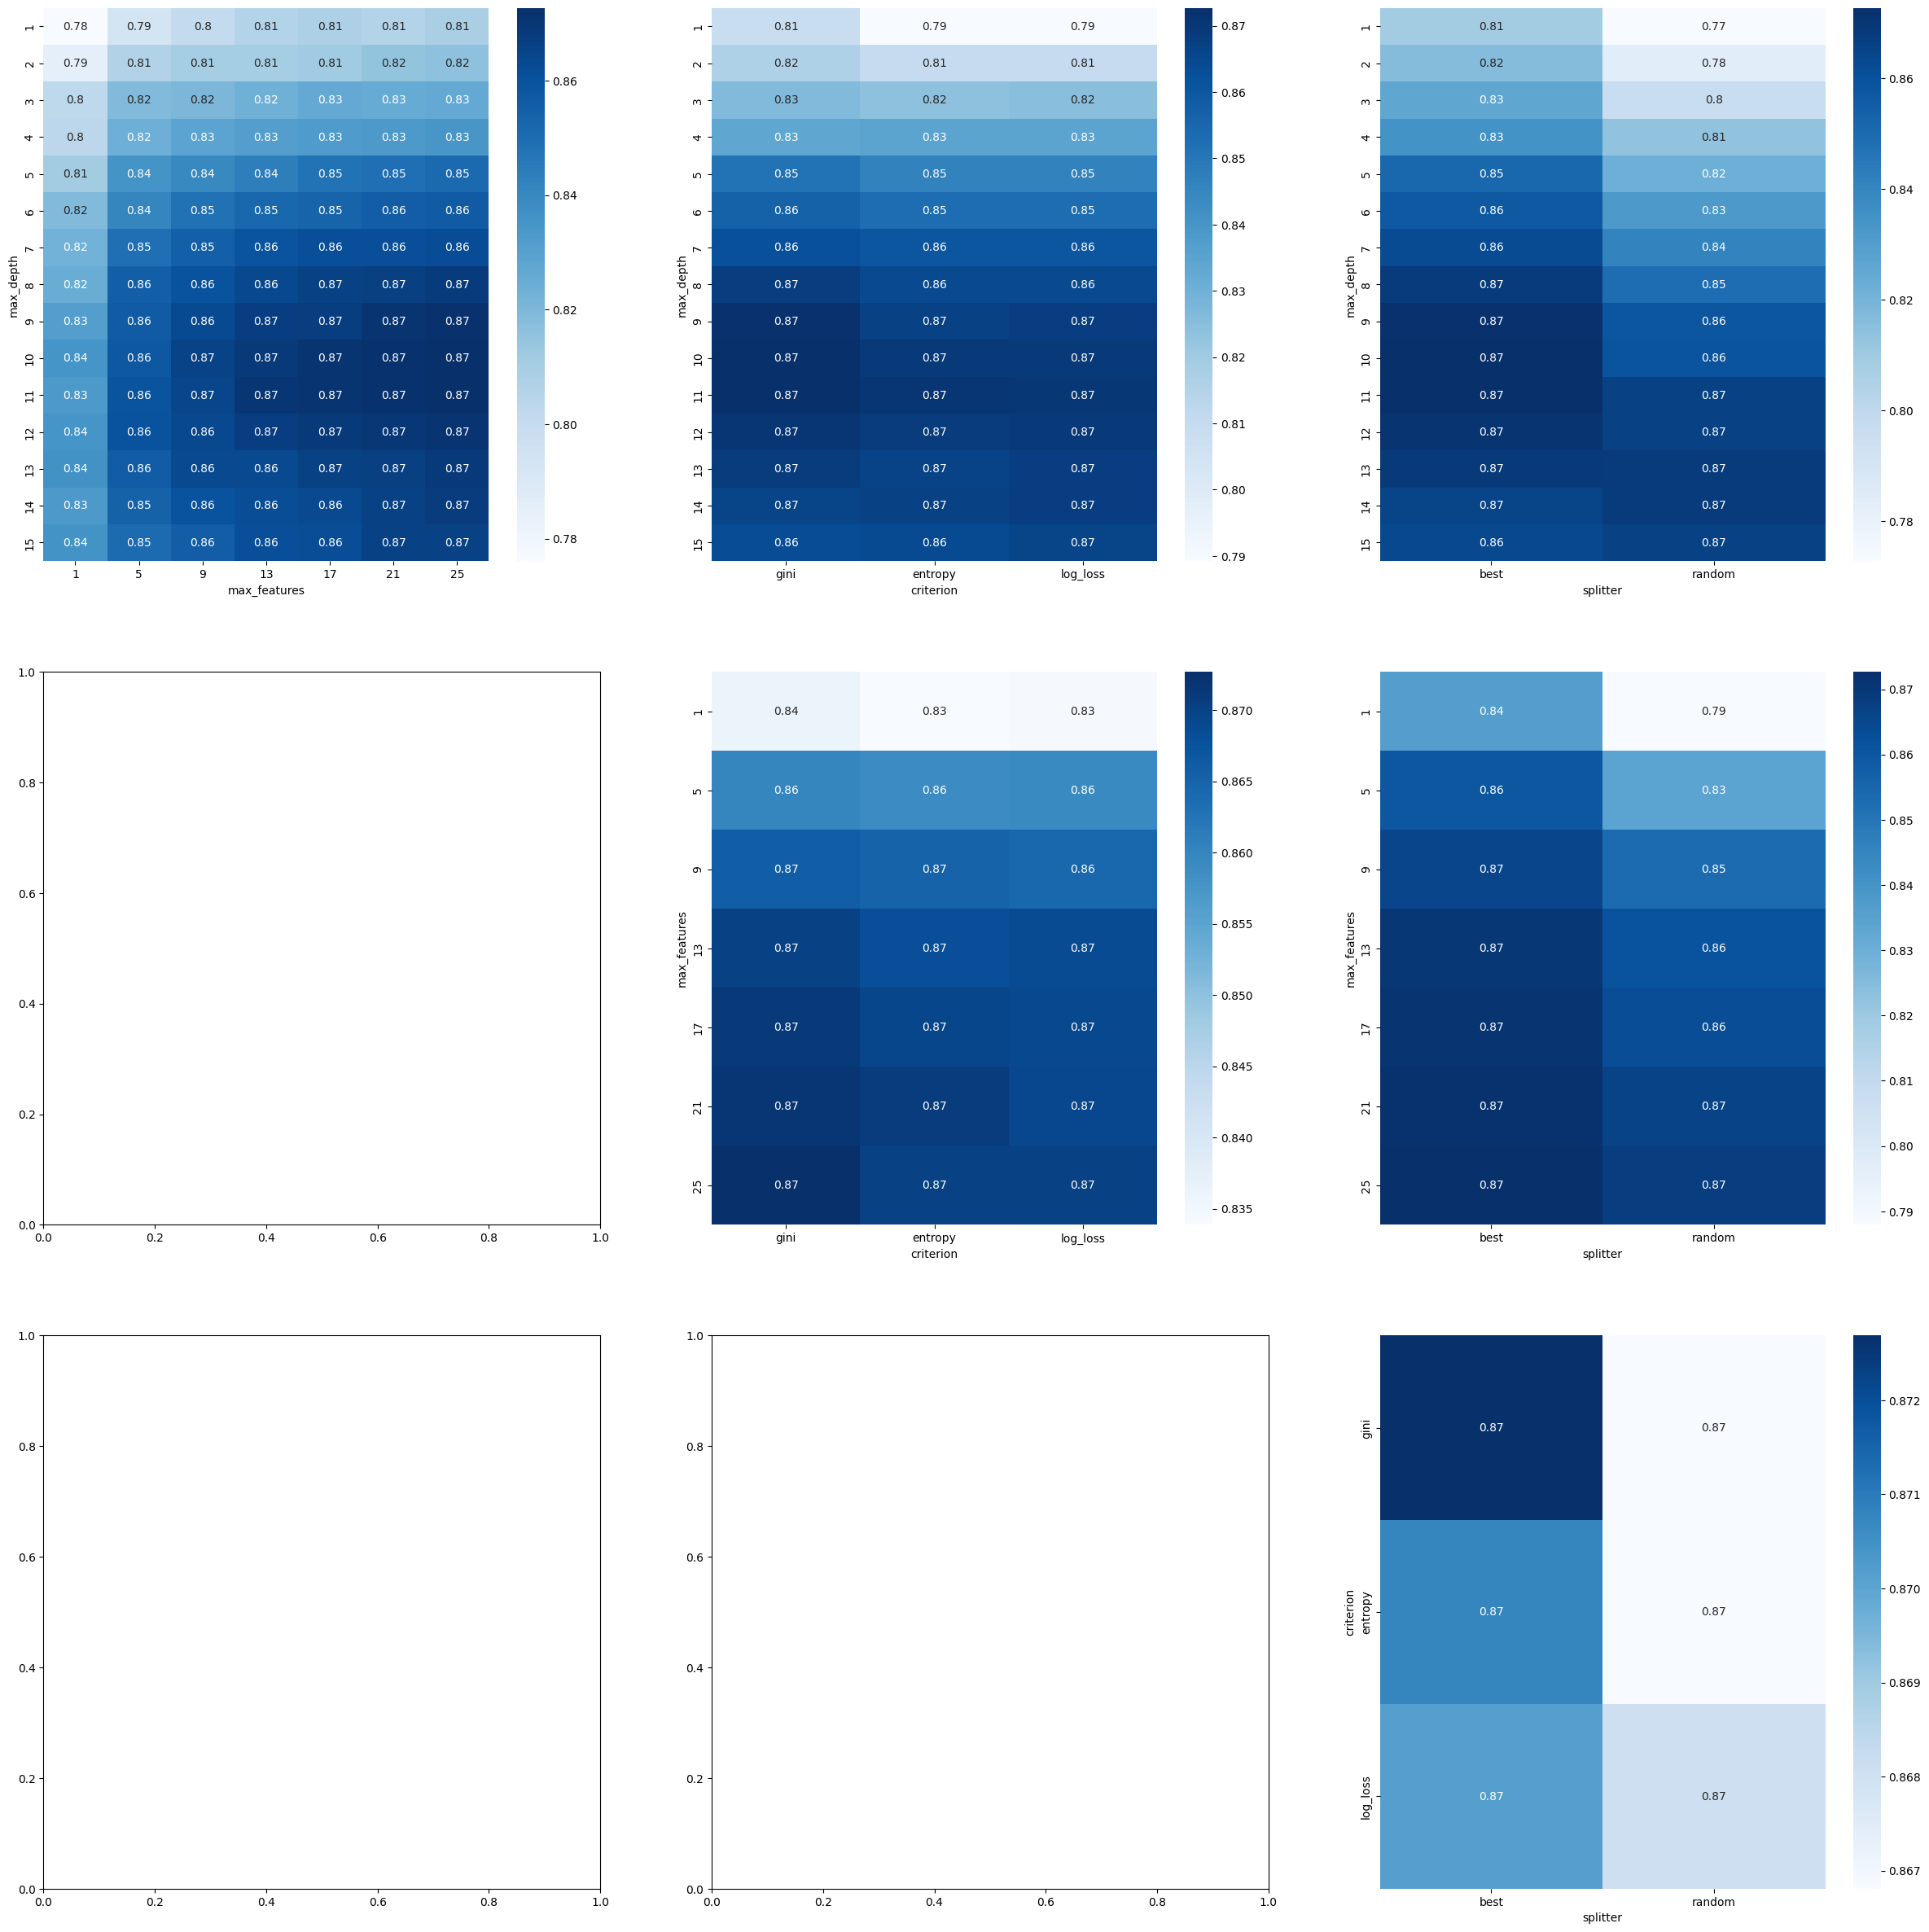

In [50]:
parameter_names = list(parameter_grid.keys())
plot_grid_search(
    grid_search,
    parameter_grid,
    parameter_names,
    "heatmaps_decision_tree.png"
)

In [46]:
plot_measures("max_depth", parameter_grid["max_depth"], grid_search.cv_results_, ["mean_test_score", "mean_train_score"], "max_depth_decision_tree.png")

KeyError: 'mean_train_score'

              precision    recall  f1-score   support

   STARBURST       0.79      0.75      0.77      6018
 STARFORMING       0.92      0.93      0.93     18352

    accuracy                           0.89     24370
   macro avg       0.85      0.84      0.85     24370
weighted avg       0.89      0.89      0.89     24370



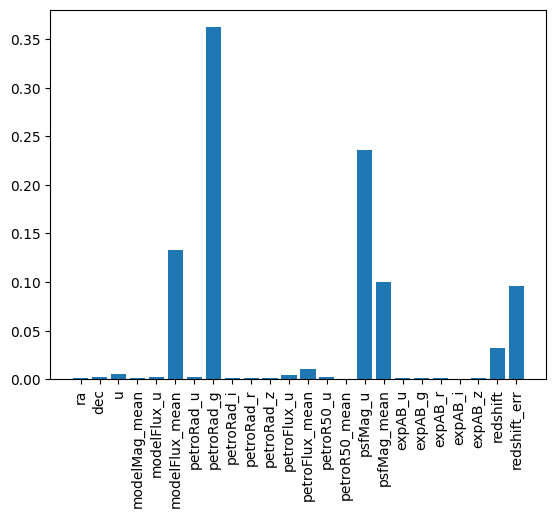

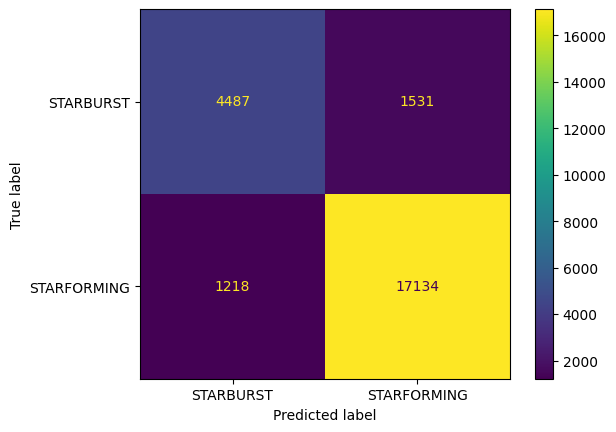

In [117]:
print_classification_report(grid_search.best_estimator_, testing_inputs, testing_classes)

## K-NN: Nearest Neighbour

In [118]:
nearest_neighbour = KNeighborsClassifier()

max_leaf_size = 40

parameter_grid_knn = {
    "n_neighbors": [1, 3, 5, 10, 20, 30, 40, 50],
    "weights": ['uniform', 'distance'],
    "algorithm": ['ball_tree', 'kd_tree', 'brute'],
    # "leaf_size": [1, 5, 10, 15, 20, 25, 30, 35, 40], # list(range(1, max_leaf_size + 1, 5))
}

print(parameter_grid_knn)

grid_search_knn = test_classifier(
    nearest_neighbour, all_inputs_normalized, all_labels, parameter_grid
)

{'n_neighbors': [1, 3, 5, 10, 20, 30, 40, 50], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}
Best score: 0.8636293848567802
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}


              precision    recall  f1-score   support

   STARBURST       0.82      0.69      0.75      5973
 STARFORMING       0.91      0.95      0.93     18397

    accuracy                           0.89     24370
   macro avg       0.86      0.82      0.84     24370
weighted avg       0.88      0.89      0.88     24370



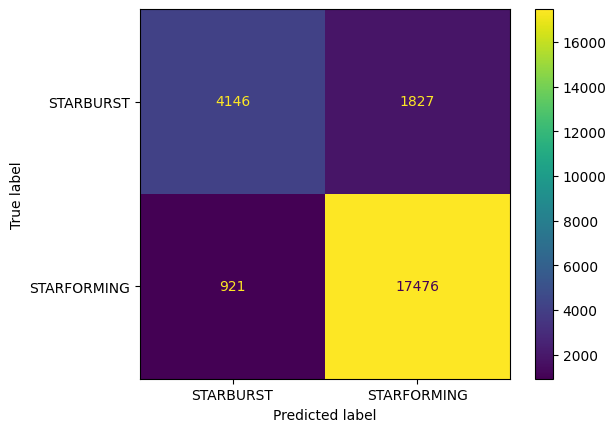

In [119]:
print_classification_report(grid_search_knn.best_estimator_, testing_inputs_normalized, testing_classes_normalized, False)

Best score: 0.8636293848567802
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}


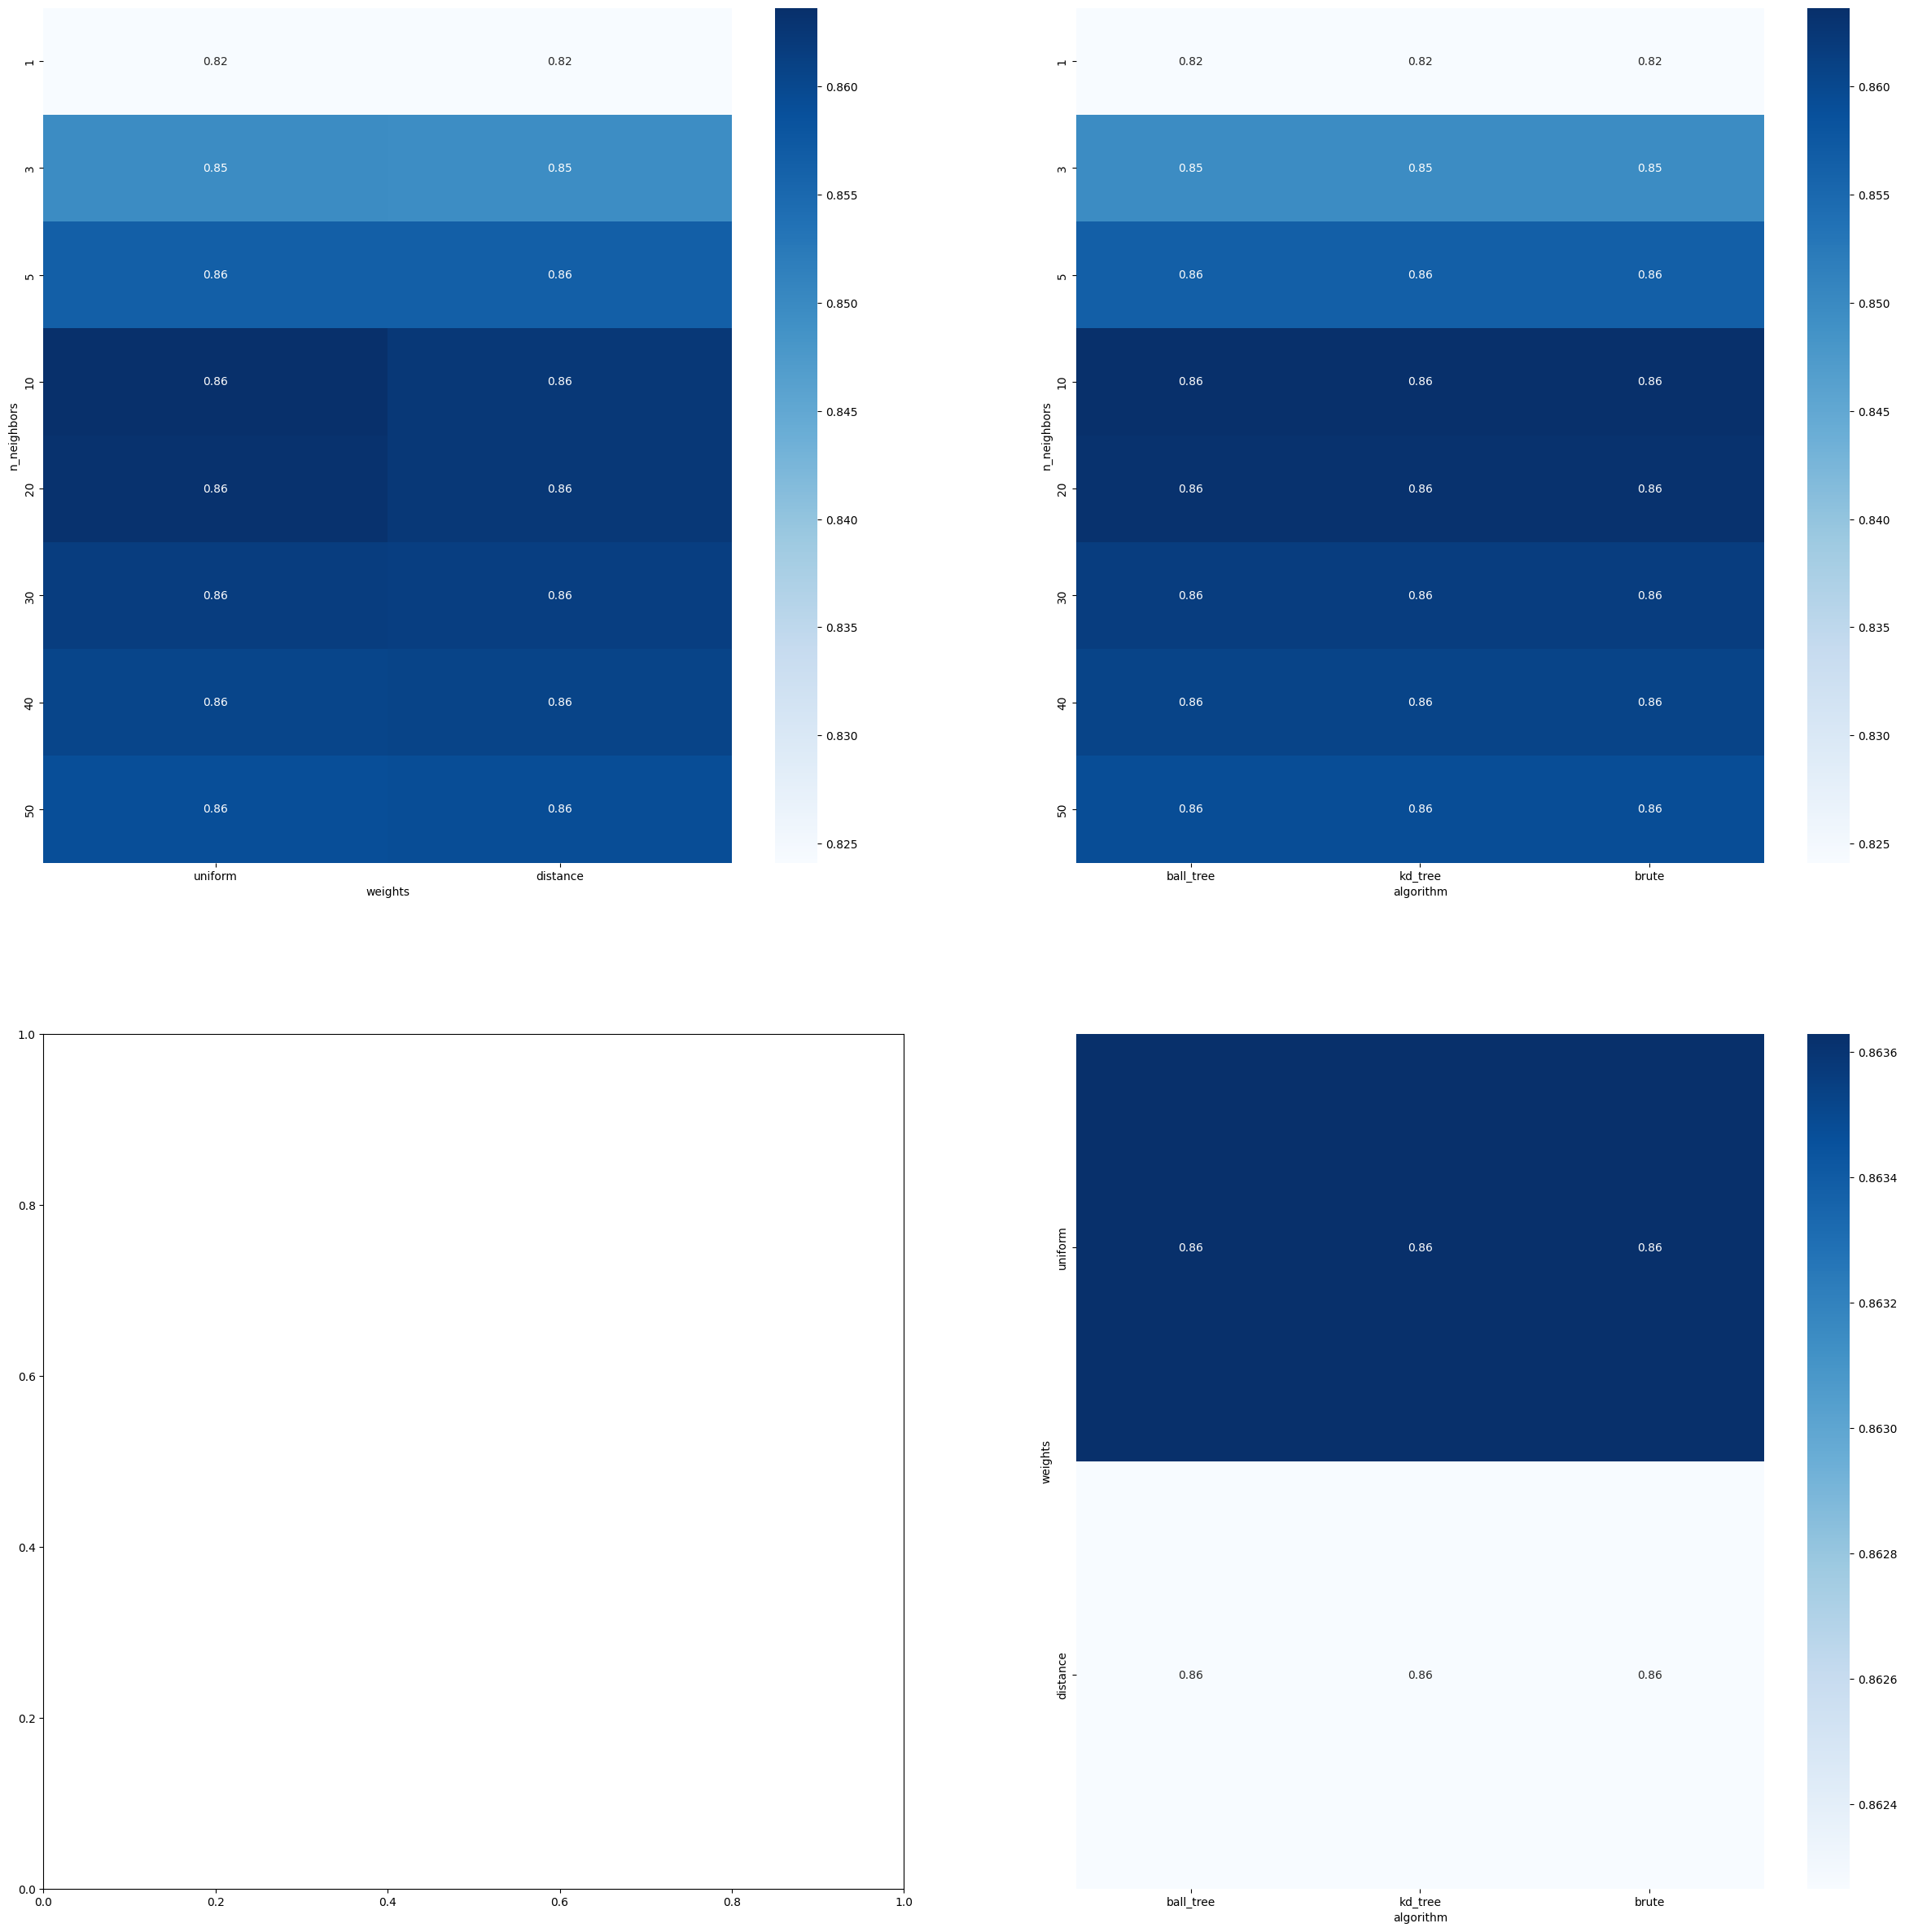

In [120]:
parameter_names_knn = list(parameter_grid_knn.keys())
plot_grid_search(
    grid_search_knn,
    parameter_grid_knn,
    parameter_names_knn,
    "heatmaps_knn"
)

## SVM: Support Vector Machine

In [121]:
C_list = [0.1, 0.5, 1, 3, 5]
gamma_list = ["scale", "auto"]
coef0_list = [-2, 0, 2]
shrinking_list = [True, False]
class_weight = ["balanced", None]

### SVM Linear

In [122]:
svm_linear = SVC()

parameter_grid_linear = {
    "C": C_list,
    "kernel": ['linear'],
    "shrinking": shrinking_list,
    "class_weight": class_weight
}

print(parameter_grid_linear)

grid_search_linear = test_classifier(
    svm_linear, inputs_under_sampl_normalized, labels_under_sampl_normalized, parameter_grid_linear
)

{'C': [0.1, 0.5, 1, 3, 5], 'kernel': ['linear'], 'shrinking': [True, False], 'class_weight': ['balanced', None]}
Best score: 0.8569310499612335
Best parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear', 'shrinking': False}


              precision    recall  f1-score   support

   STARBURST       0.65      0.86      0.74      5973
 STARFORMING       0.95      0.85      0.90     18397

    accuracy                           0.85     24370
   macro avg       0.80      0.86      0.82     24370
weighted avg       0.88      0.85      0.86     24370



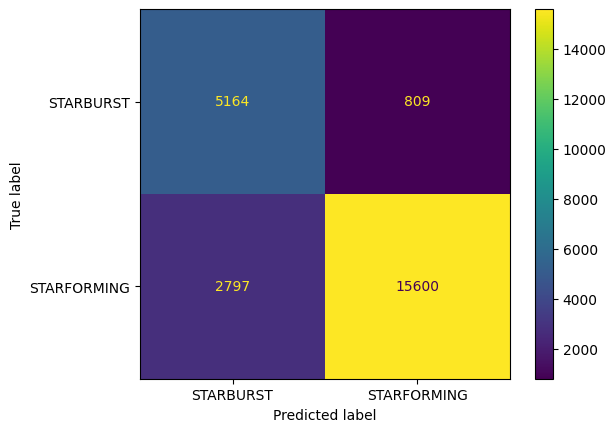

In [123]:
print_classification_report(grid_search_linear.best_estimator_, testing_inputs_normalized, testing_classes_normalized, False)

Best score: 0.8569310499612335
Best parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear', 'shrinking': False}


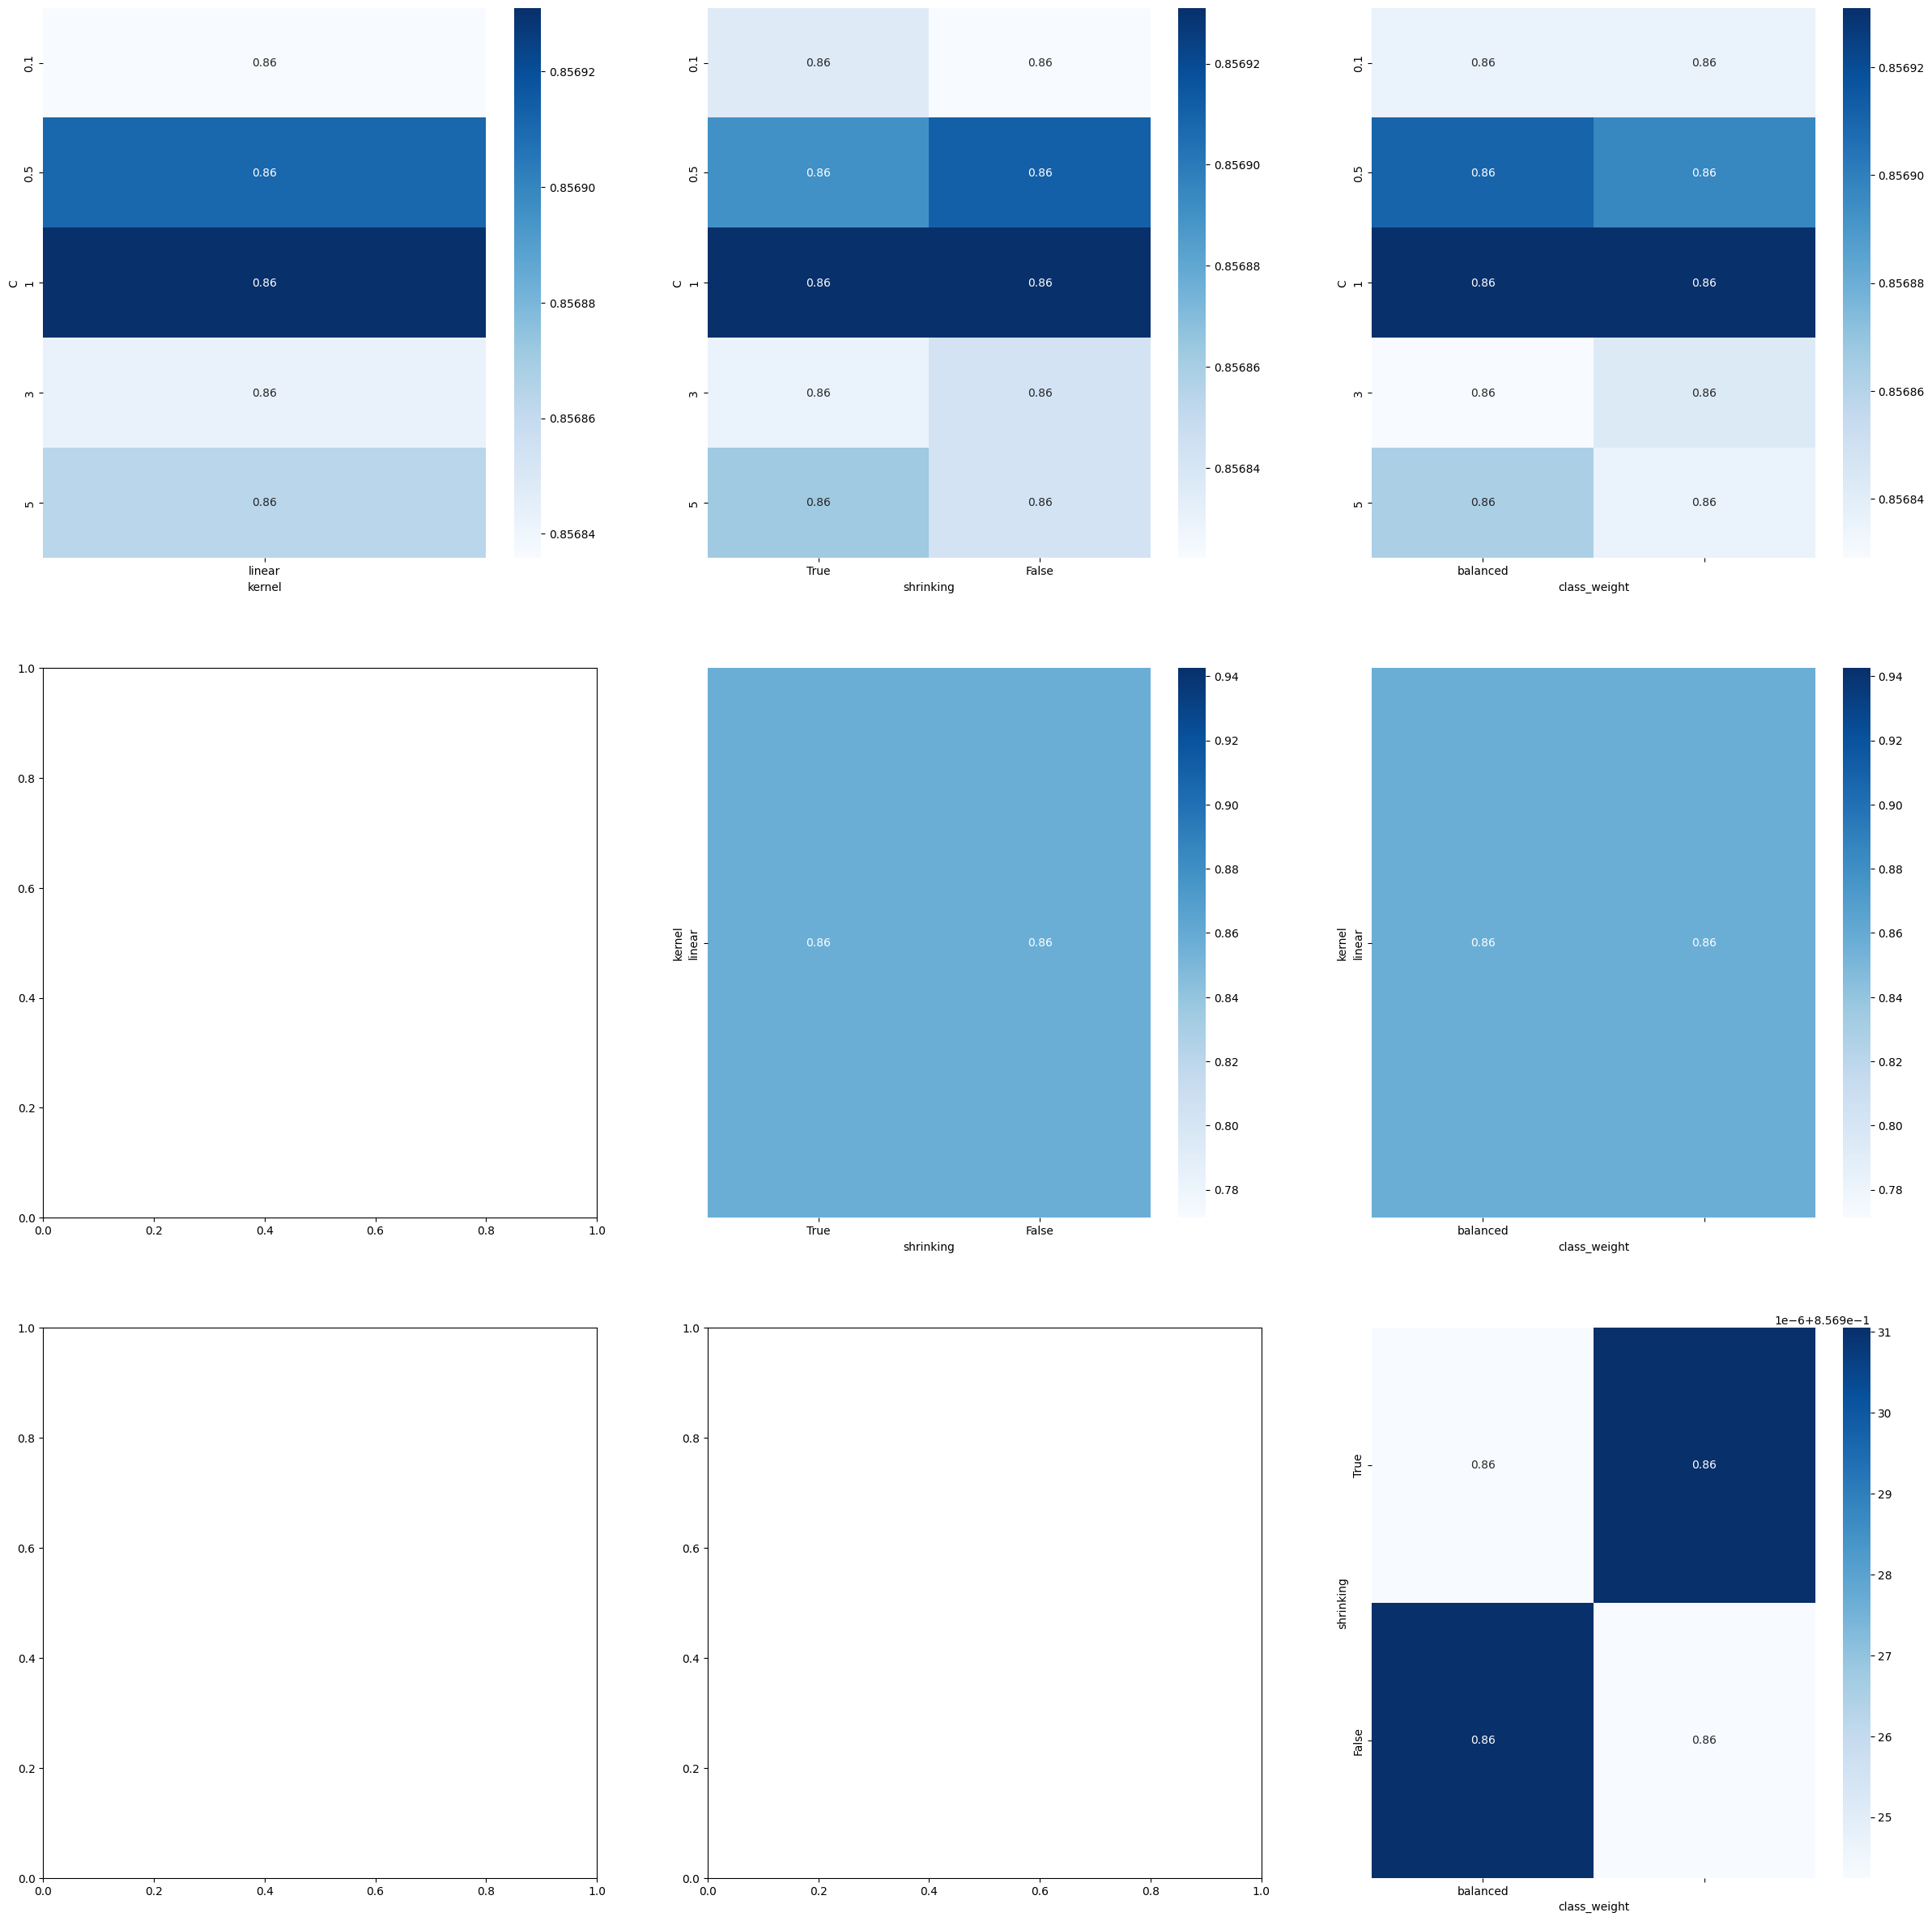

In [124]:
parameter_names_linear = list(parameter_grid_linear.keys())
plot_grid_search(
    grid_search_linear,
    parameter_grid_linear,
    parameter_names_linear,
    "heatmaps_svm_linear"
)

### SVM Polynomial

In [125]:
svm_poly = SVC()

parameter_grid_poly = {
    "C": C_list,
    "kernel": ['poly'],
    "degree": list(range(1, 6, 2)),
    "gamma": gamma_list,
    "coef0": coef0_list,
    "shrinking": shrinking_list,
    "class_weight": class_weight
}

print(parameter_grid_poly)

grid_search_poly = test_classifier(
    svm_poly, inputs_under_sampl_normalized, labels_under_sampl_normalized, parameter_grid_poly
)

{'C': [0.1, 0.5, 1, 3, 5], 'kernel': ['poly'], 'degree': [1, 3, 5], 'gamma': ['scale', 'auto'], 'coef0': [-2, 0, 2], 'shrinking': [True, False], 'class_weight': ['balanced', None]}
Best score: 0.870847245409015
Best parameters: {'C': 1, 'class_weight': 'balanced', 'coef0': 2, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'shrinking': False}


              precision    recall  f1-score   support

   STARBURST       0.69      0.90      0.78      5973
 STARFORMING       0.96      0.87      0.91     18397

    accuracy                           0.87     24370
   macro avg       0.82      0.88      0.85     24370
weighted avg       0.90      0.87      0.88     24370



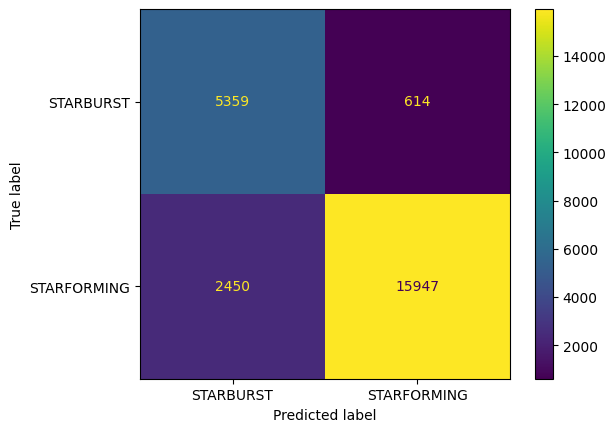

In [133]:
print_classification_report(grid_search_poly.best_estimator_, testing_inputs_normalized, testing_classes_normalized, False)

Best score: 0.870847245409015
Best parameters: {'C': 1, 'class_weight': 'balanced', 'coef0': 2, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'shrinking': False}


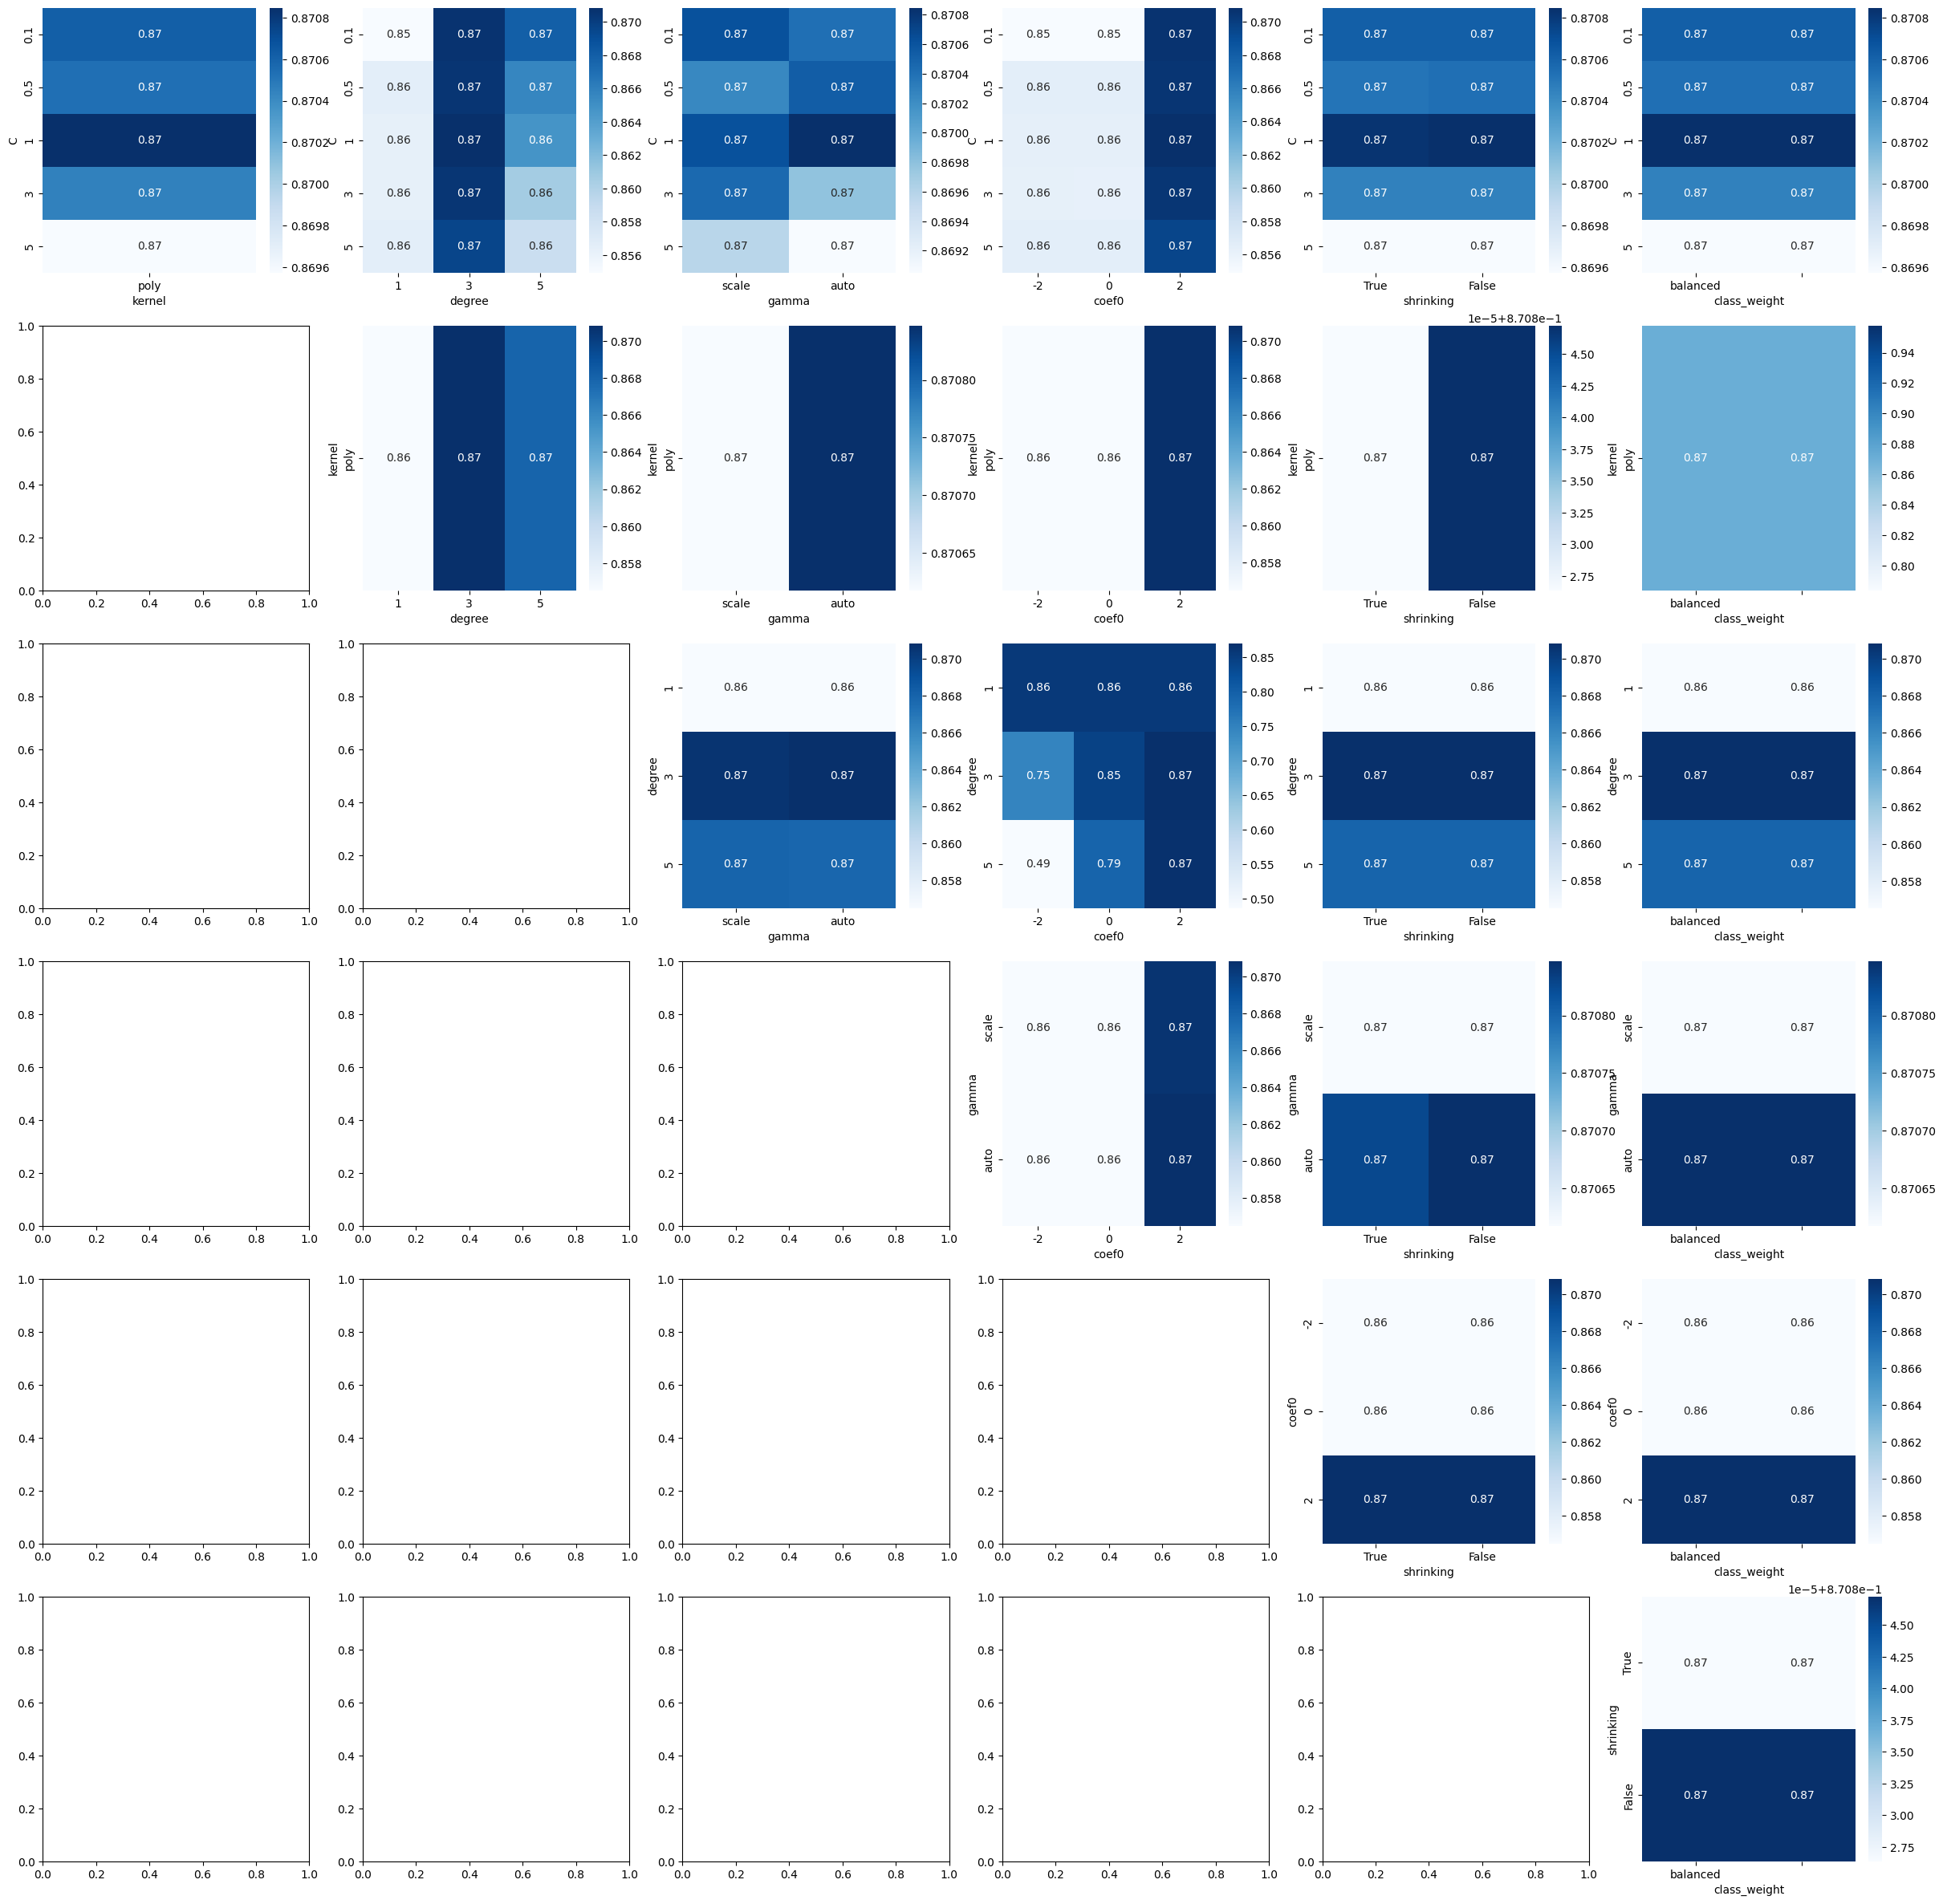

In [134]:
parameter_names_poly = list(parameter_grid_poly.keys())
plot_grid_search(
    grid_search_poly,
    parameter_grid_poly,
    parameter_names_poly,
    "heatmaps_svm_poly"
)

### SVM Radial Basis Function

In [127]:
svm_rbf = SVC()

parameter_grid_rbf = {
    "C": C_list,
    "kernel": ['rbf'],
    "gamma": gamma_list,
    "shrinking": shrinking_list,
    "class_weight": class_weight
}

print(parameter_grid_rbf)

grid_search_rbf = test_classifier(
    svm_rbf, inputs_under_sampl_normalized, labels_under_sampl_normalized, parameter_grid_rbf
)

{'C': [0.1, 0.5, 1, 3, 5], 'kernel': ['rbf'], 'gamma': ['scale', 'auto'], 'shrinking': [True, False], 'class_weight': ['balanced', None]}
Best score: 0.8709098497495826
Best parameters: {'C': 5, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True}


Best score: 0.8709098497495826
Best parameters: {'C': 5, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True}


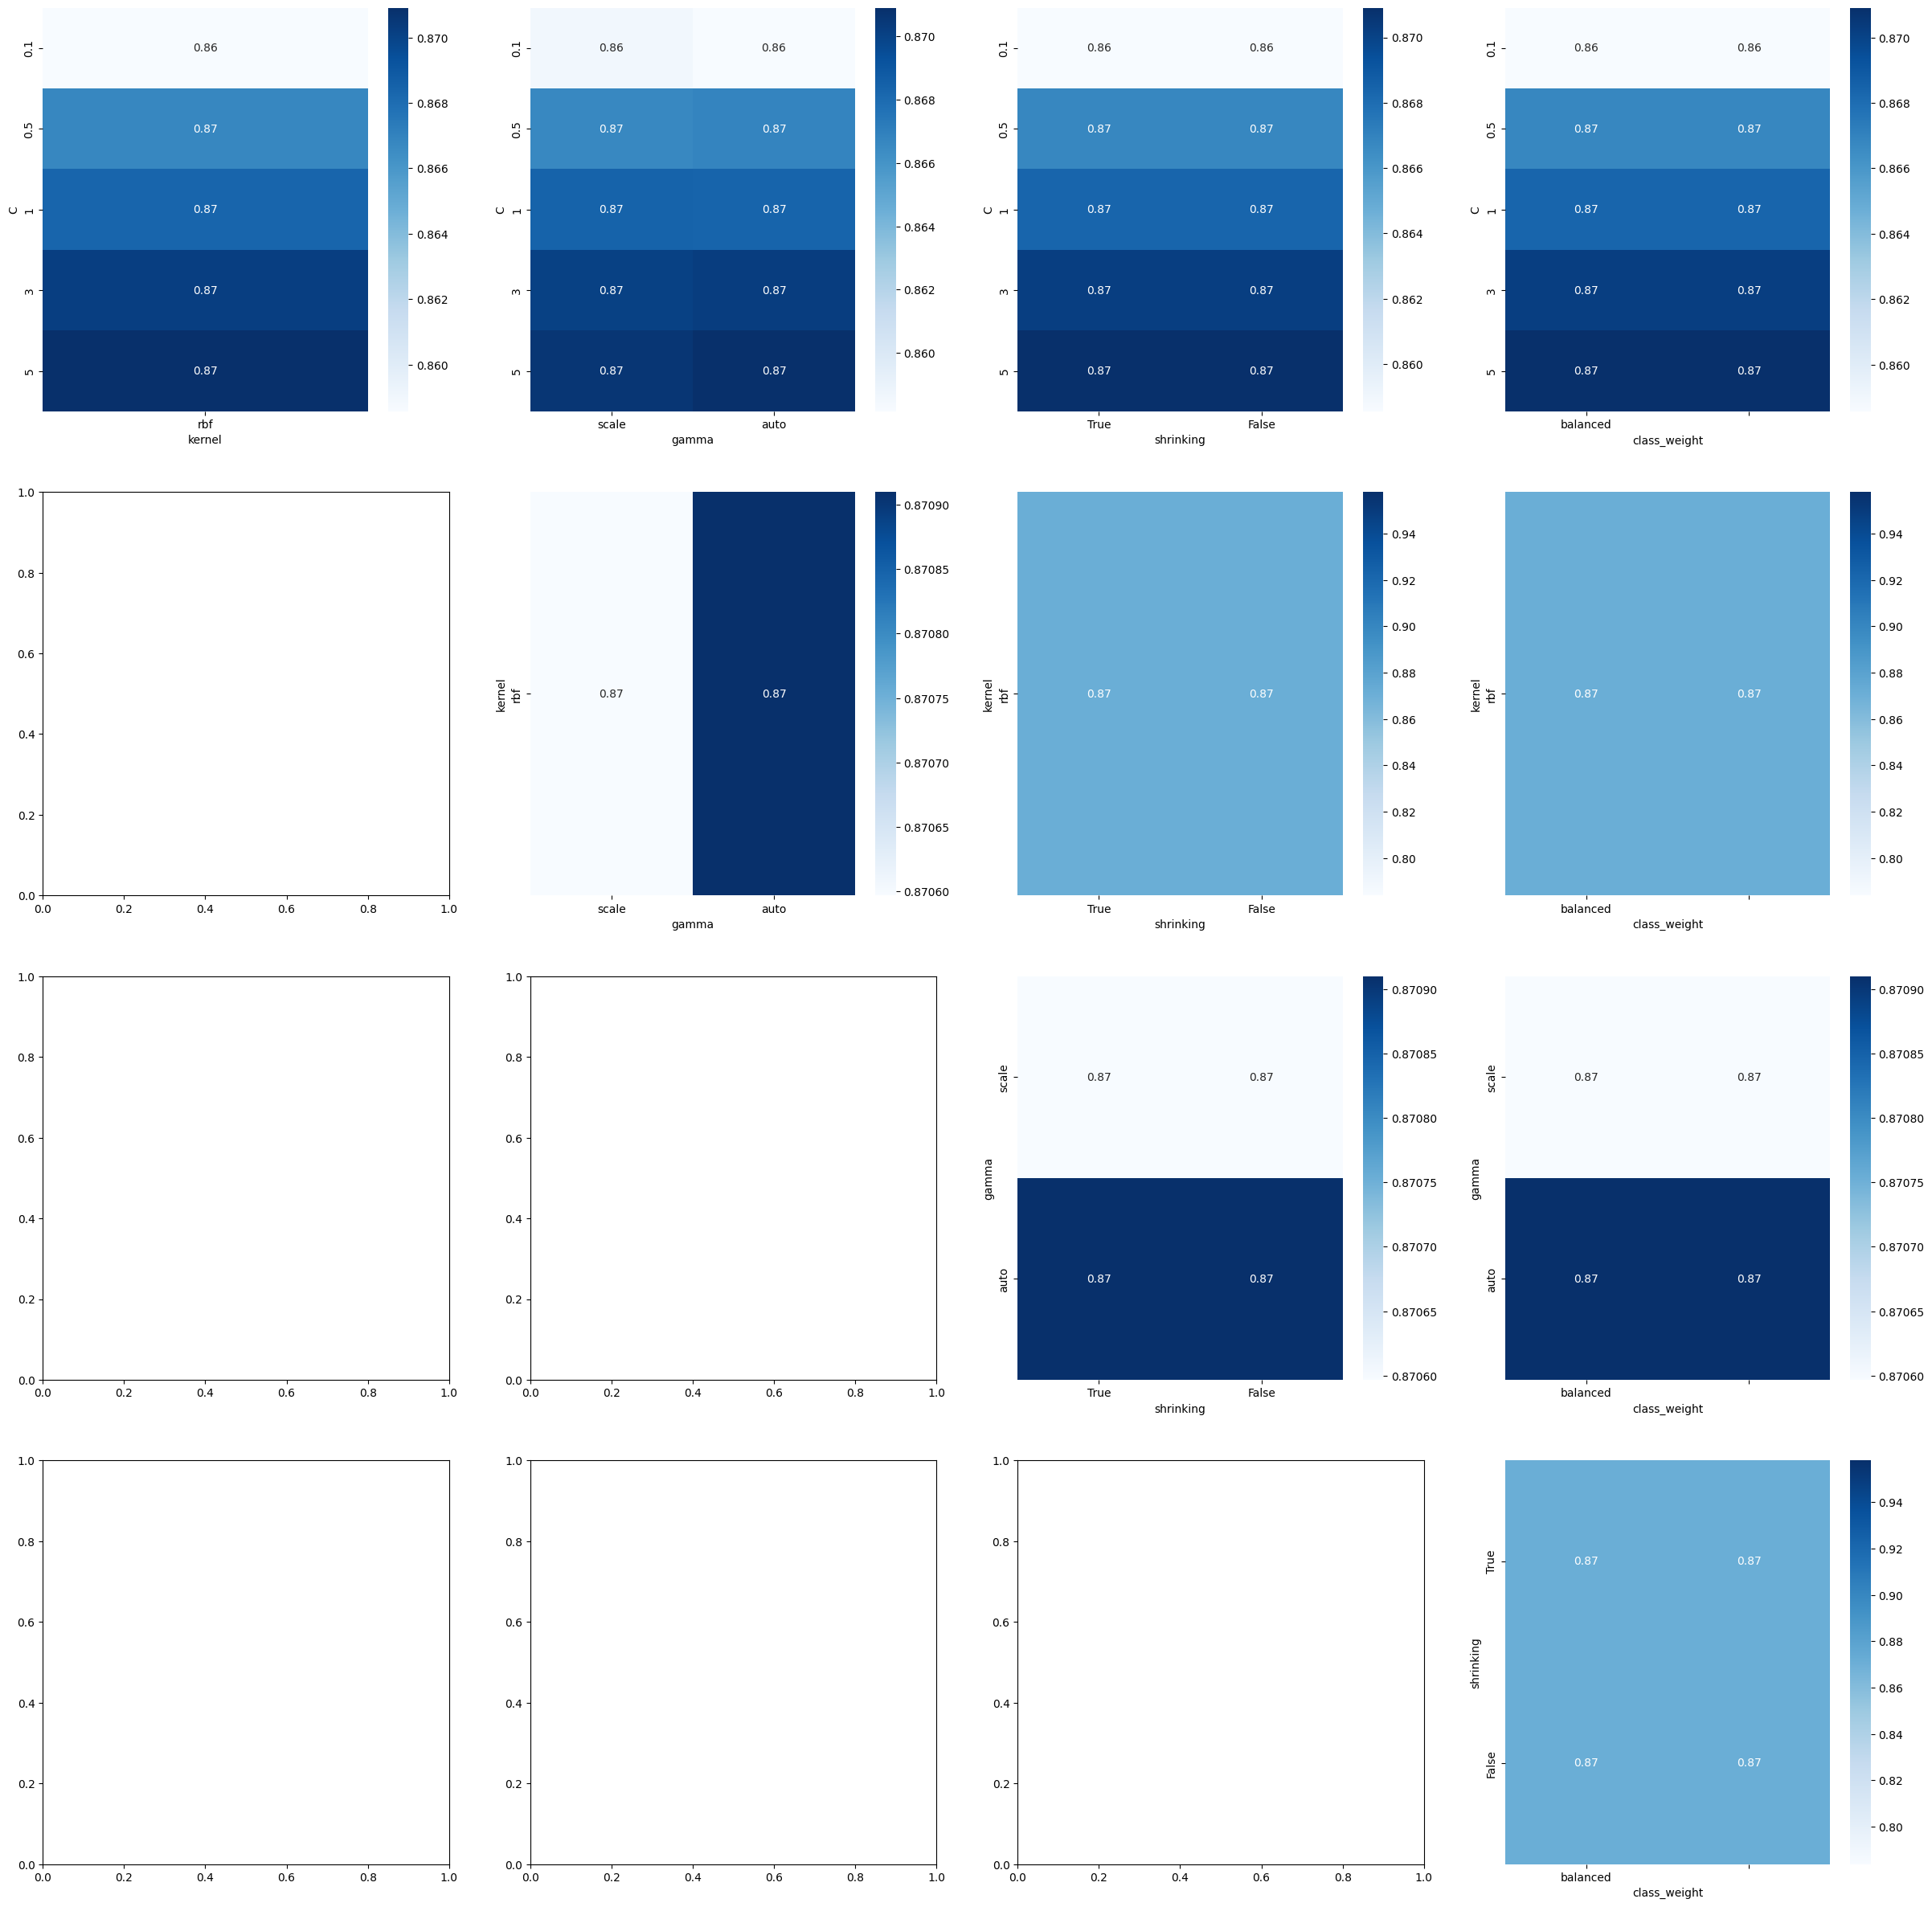

In [135]:
parameter_names_rbf = list(parameter_grid_rbf.keys())
plot_grid_search(
    grid_search_rbf,
    parameter_grid_rbf,
    parameter_names_rbf,
    "heatmaps_svm_rbf"
)

              precision    recall  f1-score   support

   STARBURST       0.69      0.90      0.78      5973
 STARFORMING       0.97      0.87      0.91     18397

    accuracy                           0.88     24370
   macro avg       0.83      0.89      0.85     24370
weighted avg       0.90      0.88      0.88     24370



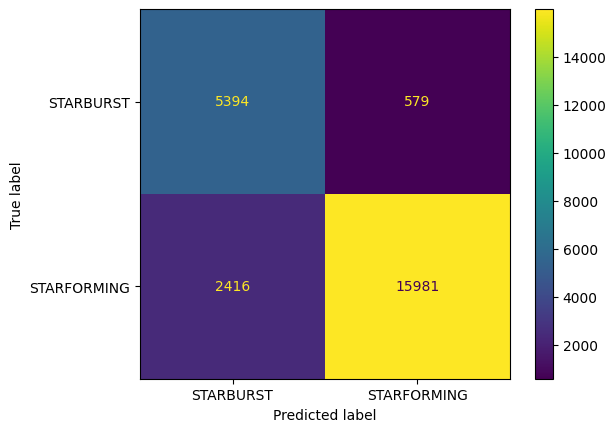

In [128]:
print_classification_report(grid_search_rbf.best_estimator_,  testing_inputs_normalized, testing_classes_normalized, False)

### SVM Sigmoid

In [129]:
svm_sigmoid = SVC()

parameter_grid_sigmoid = {
    "C": C_list,
    "kernel": ['sigmoid'], 
    "gamma": gamma_list,
    "coef0": coef0_list,
    "shrinking": shrinking_list,
    "class_weight": class_weight
}

print(parameter_grid_sigmoid)

grid_search_sigmoid = test_classifier(
    svm_sigmoid, inputs_under_sampl_normalized, labels_under_sampl_normalized, parameter_grid_sigmoid
)

{'C': [0.1, 0.5, 1, 3, 5], 'kernel': ['sigmoid'], 'gamma': ['scale', 'auto'], 'coef0': [-2, 0, 2], 'shrinking': [True, False], 'class_weight': ['balanced', None]}
Best score: 0.8168196994991652
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'coef0': -2, 'gamma': 'auto', 'kernel': 'sigmoid', 'shrinking': True}


              precision    recall  f1-score   support

   STARBURST       0.52      0.78      0.62      5973
 STARFORMING       0.91      0.76      0.83     18397

    accuracy                           0.77     24370
   macro avg       0.71      0.77      0.73     24370
weighted avg       0.82      0.77      0.78     24370



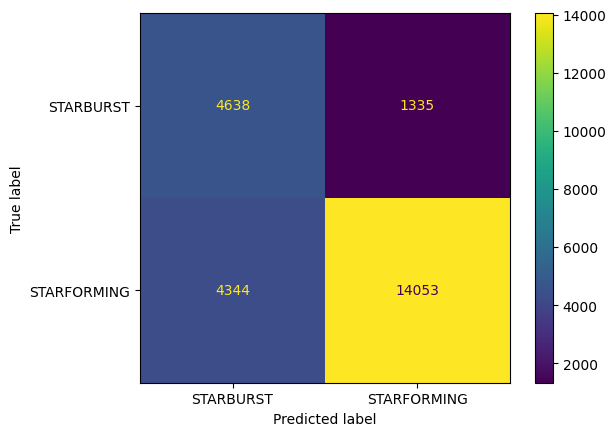

In [130]:
print_classification_report(grid_search_sigmoid.best_estimator_, testing_inputs_normalized, testing_classes_normalized, False)

Best score: 0.8168196994991652
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'coef0': -2, 'gamma': 'auto', 'kernel': 'sigmoid', 'shrinking': True}


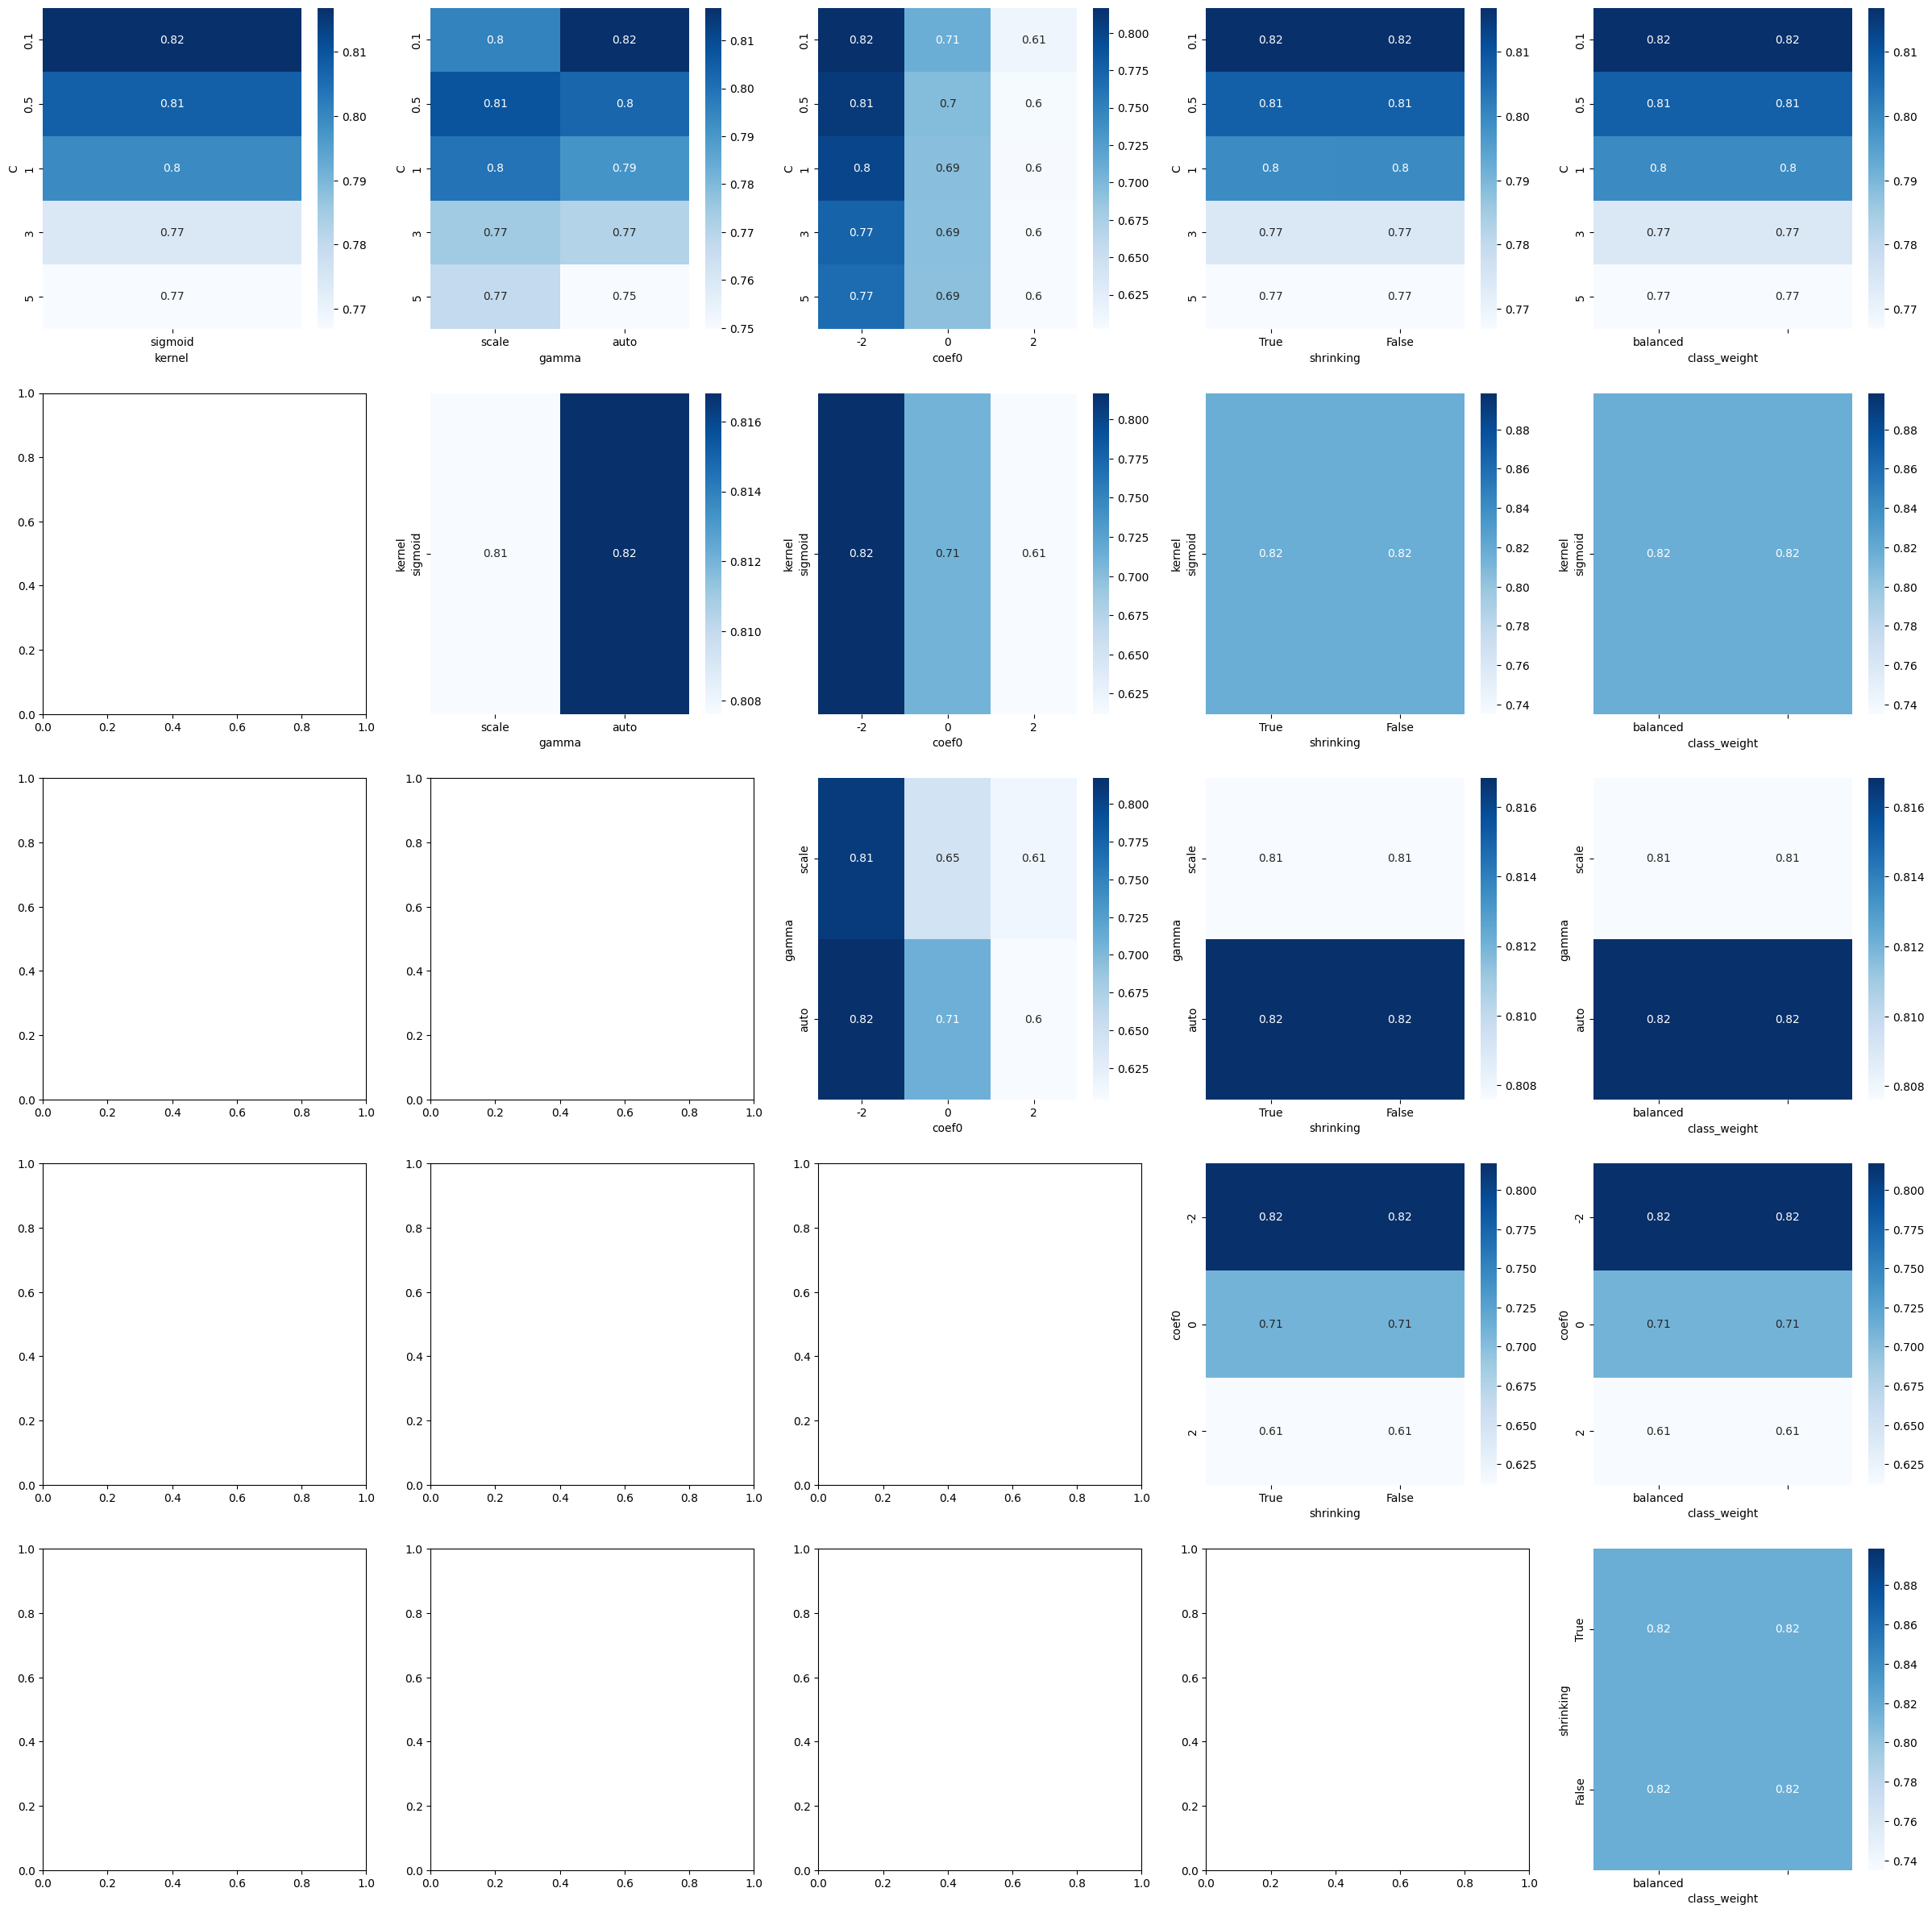

In [136]:
parameter_names_sigmoid = list(parameter_grid_sigmoid.keys())
plot_grid_search(
    grid_search_sigmoid,
    parameter_grid_sigmoid,
    parameter_names_sigmoid,
    "heatmaps_svm_sigmoid"
)

## Redes Neuronais

In [131]:
svm_sigmoid = SVC()

parameter_grid_sigmoid = {
    "C": C_list,
    "kernel": ['sigmoid'], 
    "gamma": gamma_list,
    "coef0": coef0_list,
    "shrinking": shrinking_list,
    "class_weight": class_weight
}

print(parameter_grid_sigmoid)

grid_search_sigmoid = test_classifier(
    svm_sigmoid, inputs_under_sampl_normalized, labels_under_sampl_normalized, parameter_grid_sigmoid
)

{'C': [0.1, 0.5, 1, 3, 5], 'kernel': ['sigmoid'], 'gamma': ['scale', 'auto'], 'coef0': [-2, 0, 2], 'shrinking': [True, False], 'class_weight': ['balanced', None]}
Best score: 0.8168196994991652
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'coef0': -2, 'gamma': 'auto', 'kernel': 'sigmoid', 'shrinking': True}


              precision    recall  f1-score   support

   STARBURST       0.52      0.78      0.62      5973
 STARFORMING       0.91      0.76      0.83     18397

    accuracy                           0.77     24370
   macro avg       0.71      0.77      0.73     24370
weighted avg       0.82      0.77      0.78     24370



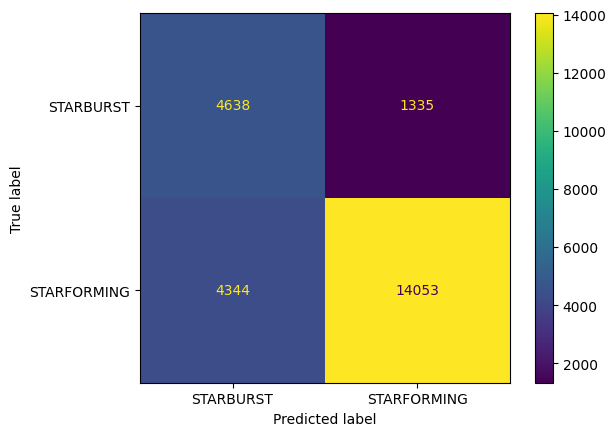

In [132]:
print_classification_report(grid_search_sigmoid.best_estimator_, testing_inputs_normalized, testing_classes_normalized, False)